# Practical Machine Learning for Physicists
## Week 2 Exercise - Part 2
## Deadline Monday 9th November at 12pm (Noon)

For both of these tasks we want you to implement autoencoder networks that:
- Train on randomly generated circles (using the circle_generator function below)
- Use 27x27 pixel images
- Use no more than 30,000 randomly generated samples (e.g. batchsize 30 and 1000 steps, or batchsize 1000 and 30 steps, or anywhere inbetween) in training the final networks for each task
- Use the mean_squared_error loss function
- Fulfil the network size requirement listed in the task (can be verifired using the print_layers function, after the network is partially trained)

### Task 1:
Implement any network design, but the bottleneck must contain no more than 9 neurons.

### Task 2:
Implement any network design, but the bottleneck must contain no more than 3 neurons.



#### Practicalities
You should use this notebook for your work and upload it to both Moodle and CoCalc. You are expected to use TensorFlow and Keras to complete these tasks. The notebook should be self-contained and able to be executed if necessary. Marks will be awarded for (roughly equally weighted):
- Overall notebook clarity (both in terms of good coding practice and coherent discussion)
- Task 1 performance (0.02 is a good target cost to do better than)
- Task 2 performance ( a good target here is left for the student to determine)



In [2]:
#importing modules
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import math

import tensorflow as tf
from tensorflow import keras


mpl.rcParams.update({'font.size': 10})
mpl.rcParams['figure.dpi']=200

In [3]:
#A big messy function to do the training
# model -- our keras neural model autoencoder
# image_generator -- a function to generate random images for the training (see below for examples)
# img_size -- the size of our image in pixels
# batchsize -- the number of images to include in each training batch
# steps -- the number of steps taken in the training
#
# returns an array of the costs
def generate_and_train(model,image_generator,img_size,batchsize,steps):
   
    #Generate an array of the numbers 1 to img_size and create a meshgrid from them    
    pixels=np.linspace(-1,1,img_size)
    x,y=np.meshgrid(pixels,pixels)
    
    #Now create a test image using 1 call to image_generator
    #y_test=np.zeros([1,pixels,pixels,1])
    #y_test[:,:,:,0]=image_generator(1,x,y)
    
    #Now create the empty arrays for the images and cost
    y_in=np.zeros([batchsize,img_size,img_size,1])
    y_target=np.zeros([batchsize,img_size,img_size,1])
    cost=np.zeros(steps)
    
    #Loop through the steps, get a random batch of samples, train the model, repeat
    for k in range(steps):
        # produce samples:
        y_in[:,:,:,0]=image_generator(batchsize,x,y)
        y_target=np.copy(y_in) # autoencoder wants to reproduce its input!
        
        # do one training step on this batch of samples:
        cost[k]=model.train_on_batch(y_in,y_target)
    
    return cost,y_target

def get_test_image(image_generator,img_size):
    #Generate an array of the numbers 1 to img_size and create a meshgrid from them    
    pixels=np.linspace(-1,1,img_size)
    x,y=np.meshgrid(pixels,pixels)
    
    #Now create a test image using 1 call to image_generator
    y_test=np.zeros([1,img_size,img_size,1])
    y_test[:,:,:,0]=image_generator(1,x,y)
    return y_test

# A function to generate and plot a single test image and the output of our model
# only to be called after training the model
def plot_test_image(model,image_generator,img_size):
    #Get random test image
    y_test=get_test_image(image_generator,img_size)
    
    #Create the output image
    y_test_out=model.predict_on_batch(y_test)
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(y_test[0,:,:,0],origin='lower')
    ax[0].set_title("Input")
    ax[1].imshow(y_test_out[0,:,:,0],origin='lower')
    ax[1].set_title("Output")
    
def print_layers(network, y_in):
    """
    Call this on some test images y_in, to get a print-out of
    the layer sizes. Shapes shown are (batchsize,pixels,pixels,channels).
    After a call to the visualization routine, y_target will contain
    the last set of training images, so you could feed those in here.
    """
    layer_features=get_layer_activations(network,y_in)
    #print(layer_features)
    for idx,feature in enumerate(layer_features):
        s=np.shape(feature)
        print("Layer "+str(idx)+": "+str(s[1]*s[2]*s[3])+" neurons / ", s)

def get_layer_activation_extractor(network):
    #print(network.inputs)
    #for layer in network.layers:
    #    print(layer.output)
    return(keras.Model(inputs=network.inputs,
                            outputs=[layer.output for layer in network.layers]))

def get_layer_activations(network, y_in):
    """
    Call this on some test images y_in, to get the intermediate 
    layer neuron values. These are returned in a list, with one
    entry for each layer (the entries are arrays).
    """
    extractor=get_layer_activation_extractor(network)
    #print(extractor)
    layer_features = extractor(y_in)
    return layer_features
    

## Circle generator


In [4]:
# A simple image generator that returns an array of batchsize images
# each image has a size of x * y pixels
# in this image each image has a randomly placed circle (and the circle is of random size)
def circle_generator(batchsize,x,y):
    R=np.random.uniform(size=batchsize)
    x0=np.random.uniform(size=batchsize,low=-1,high=1)
    y0=np.random.uniform(size=batchsize,low=-1,high=1)
    return( 1.0*((x[None,:,:]-x0[:,None,None])**2 + (y[None,:,:]-y0[:,None,None])**2 < R[:,None,None]**2) )


## 1) Convolutional NN with a bottle neck of no more than 9 neurons

In the code below an autoencoder nerual network is created to take in an input image of size 27x27 pixels and to encode this using a convoluational network structure as well as downsampling to get a respresentation of this image in through a 9 neuron 'bottleneck'. From there on the image is upsampled and attempted to be reconstructed to its original form. 

This is an exploration into how the structure of the autoencoder network, specifically the form of the convolutional and down/upsampling layers affects the efficacy of the autoencoder as a whole. This efficacy is measured by the cost function which uses the mean squared error. The aim of this exploration was to bring the final cost function as low as possible whilst keeping the number of layers to a minimum to maximise efficiency.

For the activation functions of each of the layers Relu has been employed as it is more efficient to calculate than sigmoid and other functions and is also very effective for the network and requires less computation to arrive at the same result.

In [66]:
#creating the network model with a bottleneck of no more than 9 neurons
model=keras.models.Sequential()

model.add(keras.layers.Conv2D(5,5,input_shape=(None,None,1),activation="relu",padding='same'))
model.add(keras.layers.AveragePooling2D(pool_size=(3,3),padding='same')) # down
model.add(keras.layers.Conv2D(5,3,activation="relu",padding='same'))
model.add(keras.layers.AveragePooling2D(pool_size=(3,3),padding='same')) # down
model.add(keras.layers.Conv2D(1,3,activation="relu",padding='same'))
model.add(keras.layers.UpSampling2D(size=(3,3))) # up
model.add(keras.layers.Conv2D(4,3,activation="relu",padding='same'))
model.add(keras.layers.UpSampling2D(size=(3,3))) # up
model.add(keras.layers.Conv2D(4,5,activation="relu",padding='same'))
model.add(keras.layers.Conv2D(1,5,activation="relu",padding='same'))

#compiling model
model.compile(loss='mean_squared_error',optimizer='adam')

model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_98 (Conv2D)           (None, None, None, 5)     130       
_________________________________________________________________
average_pooling2d_32 (Averag (None, None, None, 5)     0         
_________________________________________________________________
conv2d_99 (Conv2D)           (None, None, None, 5)     230       
_________________________________________________________________
average_pooling2d_33 (Averag (None, None, None, 5)     0         
_________________________________________________________________
conv2d_100 (Conv2D)          (None, None, None, 1)     46        
_________________________________________________________________
up_sampling2d_32 (UpSampling (None, None, None, 1)     0         
_________________________________________________________________
conv2d_101 (Conv2D)          (None, None, None, 4)   

Final cost is: [0.01457311]


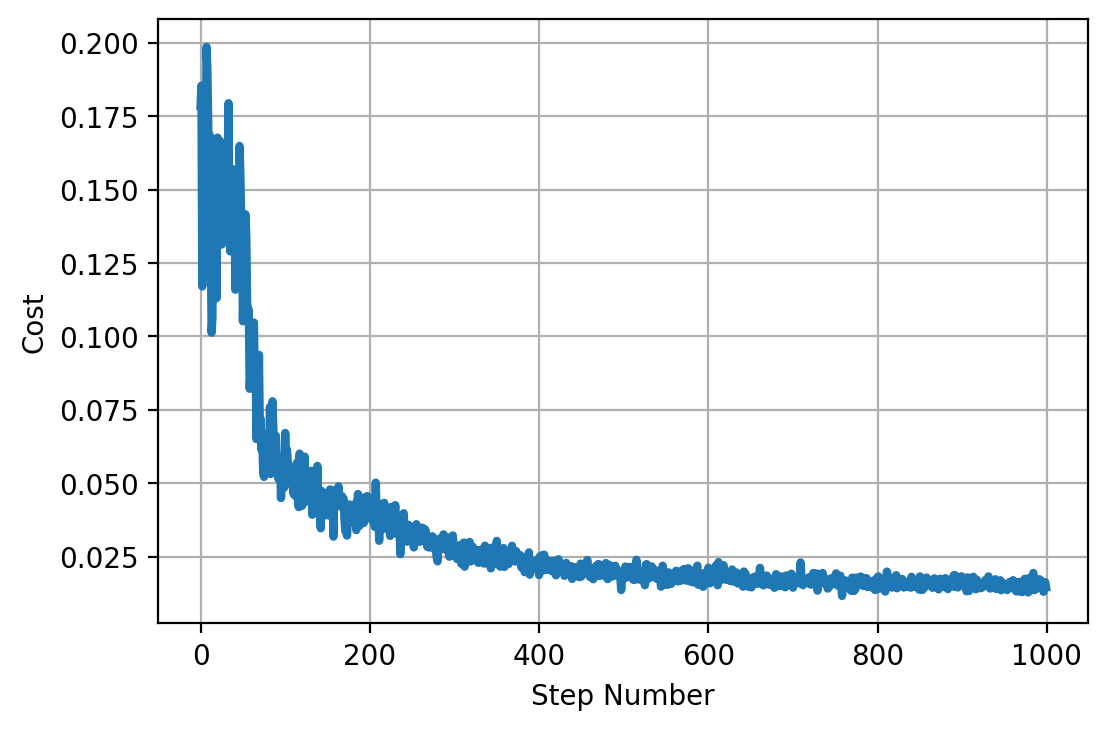

In [67]:
#training the model

steps=1000
cost,y_target=generate_and_train(model,circle_generator,img_size=27,batchsize=30,steps=steps)
#Plot the cost
fig, ax = plt.subplots()
stepArray=np.arange(steps) 
ax.plot(stepArray,cost,linewidth=3) 
ax.set_xlabel("Step Number") 
ax.set_ylabel("Cost")
ax.grid()


print('Final cost is:', cost[-1:])

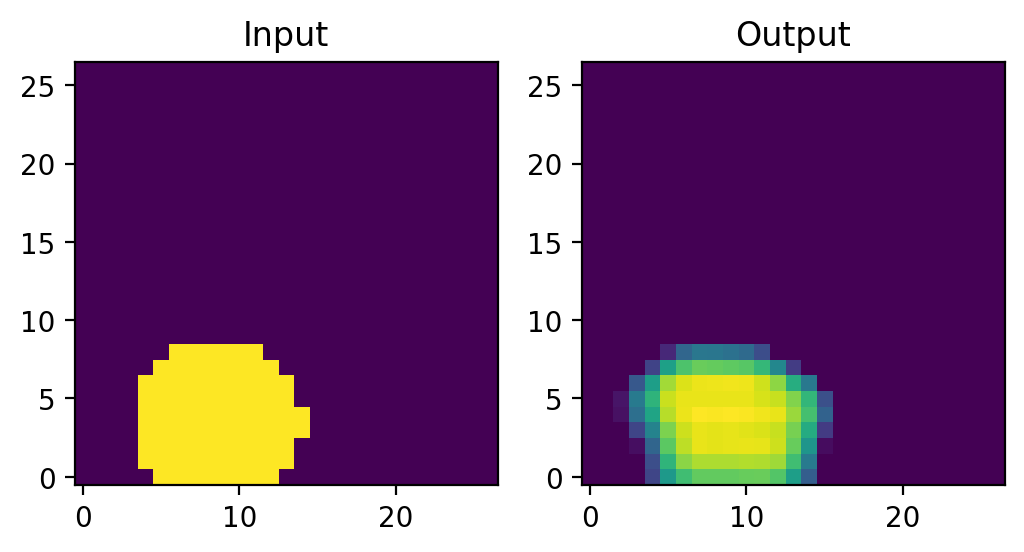

In [137]:
#replotting the test image of the input and output after training the model
plot_test_image(model,circle_generator,27)

In [64]:
#printing out a summary of all the layers in the model
print_layers(model,y_target)

Layer 0: 3645 neurons /  (30, 27, 27, 5)
Layer 1: 405 neurons /  (30, 9, 9, 5)
Layer 2: 405 neurons /  (30, 9, 9, 5)
Layer 3: 45 neurons /  (30, 3, 3, 5)
Layer 4: 9 neurons /  (30, 3, 3, 1)
Layer 5: 81 neurons /  (30, 9, 9, 1)
Layer 6: 324 neurons /  (30, 9, 9, 4)
Layer 7: 2916 neurons /  (30, 27, 27, 4)
Layer 8: 2916 neurons /  (30, 27, 27, 4)
Layer 9: 729 neurons /  (30, 27, 27, 1)


## 2) Convolutional NN with a bottleneck of no more than 3 neurons

This next section of the notebook is very similar to section 1, however the difference here is that the network that is being optimised has a 'bottleneck' of fewer neurons than the last netork, specifically this bottleneck has 3 neurons, which means that it will be even more difficult to pass enough pertient information through to reconstruct and accurate image of the original.

More convolutional layers and up/downsampling layers are used in an effort to decrease the final cost function, which is still higher than the previous cost function. At the same time, the kernel sizes within these convolutional layers are kept small as it appears that smaller kernels tend to be more efficient not only for pure calculations but also are more effective at decreasing the cost function.

In [14]:
#creating the network model with a bottleneck of no more than 9 neurons
model2=keras.models.Sequential()

model2.add(keras.layers.Conv2D(10,5,input_shape=(None,None,1),activation="relu",padding='same'))
model2.add(keras.layers.AveragePooling2D(pool_size=(3,3),padding='same')) # down
model2.add(keras.layers.Conv2D(5,3,activation="relu",padding='same'))
model2.add(keras.layers.AveragePooling2D(pool_size=(3,3),padding='same')) # down
model2.add(keras.layers.Conv2D(5,3,activation="relu",padding='same'))
model2.add(keras.layers.AveragePooling2D(pool_size=(3,3),padding='same')) # down
model2.add(keras.layers.Conv2D(3,2,activation="relu",padding='same'))
model2.add(keras.layers.UpSampling2D(size=(3,3))) # up
model2.add(keras.layers.Conv2D(4,3,activation="relu",padding='same'))
model2.add(keras.layers.UpSampling2D(size=(3,3))) # up
model2.add(keras.layers.Conv2D(4,3,activation="relu",padding='same'))
model2.add(keras.layers.UpSampling2D(size=(3,3))) # up
model2.add(keras.layers.Conv2D(4,5,activation="relu",padding='same'))
model2.add(keras.layers.Conv2D(1,5,activation="relu",padding='same'))

#compiling model
model2.compile(loss='mean_squared_error',optimizer='adam')

model2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, None, None, 10)    260       
_________________________________________________________________
average_pooling2d_12 (Averag (None, None, None, 10)    0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, None, None, 5)     455       
_________________________________________________________________
average_pooling2d_13 (Averag (None, None, None, 5)     0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, None, None, 5)     230       
_________________________________________________________________
average_pooling2d_14 (Averag (None, None, None, 5)     0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, None, None, 3)    

Final cost is: [0.03345519]


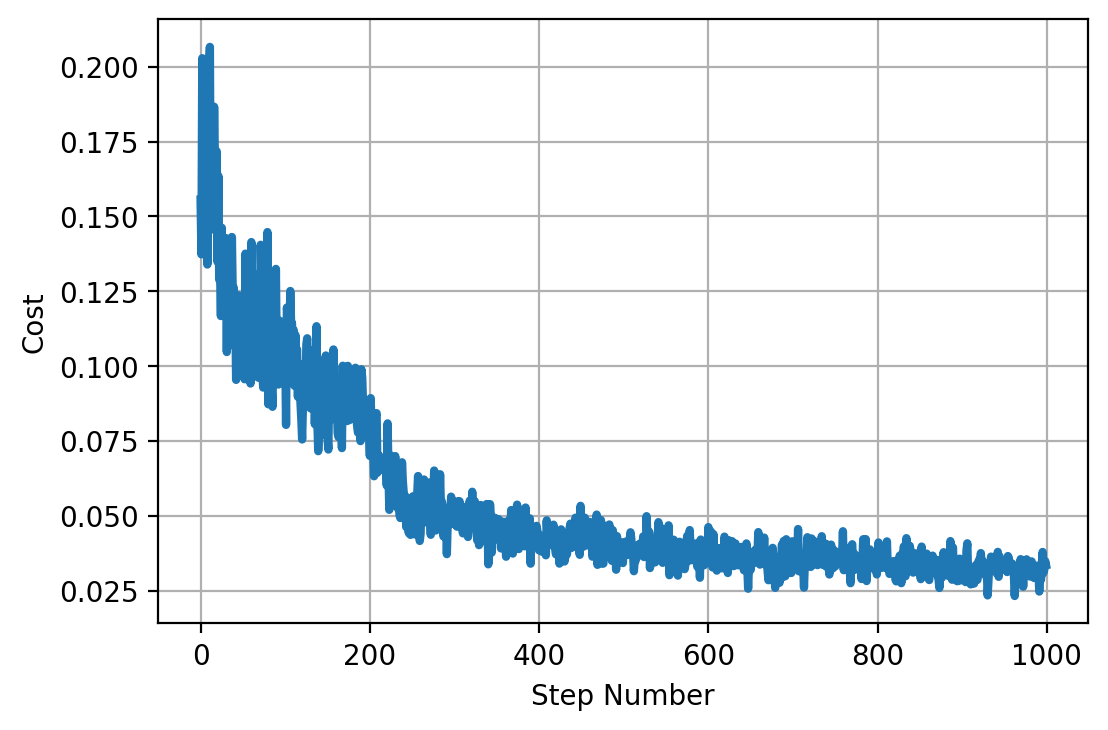

In [15]:
#training the model

steps2=1000
cost,y_target=generate_and_train(model2,circle_generator,img_size=27,batchsize=30,steps=steps2)
#Plot the cost
fig, ax = plt.subplots()
stepArray=np.arange(steps2) 
ax.plot(stepArray,cost,linewidth=3) 
ax.set_xlabel("Step Number") 
ax.set_ylabel("Cost")
ax.grid()


print('Final cost is:', cost[-1:])

In [104]:
#printing out a summary of all the layers in the model
print_layers(model2,y_target)

Layer 0: 7290 neurons /  (30, 27, 27, 10)
Layer 1: 810 neurons /  (30, 9, 9, 10)
Layer 2: 405 neurons /  (30, 9, 9, 5)
Layer 3: 45 neurons /  (30, 3, 3, 5)
Layer 4: 45 neurons /  (30, 3, 3, 5)
Layer 5: 5 neurons /  (30, 1, 1, 5)
Layer 6: 3 neurons /  (30, 1, 1, 3)
Layer 7: 27 neurons /  (30, 3, 3, 3)
Layer 8: 45 neurons /  (30, 3, 3, 5)
Layer 9: 405 neurons /  (30, 9, 9, 5)
Layer 10: 405 neurons /  (30, 9, 9, 5)
Layer 11: 3645 neurons /  (30, 27, 27, 5)
Layer 12: 2916 neurons /  (30, 27, 27, 4)
Layer 13: 729 neurons /  (30, 27, 27, 1)


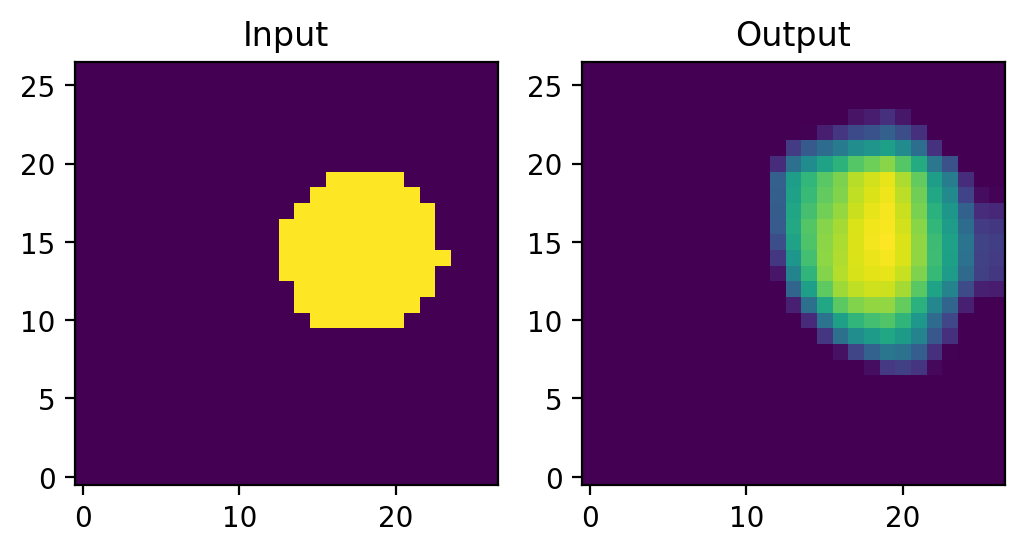

In [16]:
#replotting the test image of the input and output after training the model
plot_test_image(model2,circle_generator,27)

## Conclusion

When comparing the two sections of this notebook it is possible to see that the autoencoder with a larger bottleneck is less computationally expensive and has a lower cost function compared to the autoencoder with a smaller bottleneck of 3 neurons. This does not mean that the bottleneck with 3 neurons is less valuable however, as the autoencoder with a 3 neuron bottleneck is a more powerful encoder as it condense the information more and given more computational power may return the same cost function. This smaller bottleneck over time creates a more efficient encoder which may be applied to similar tasks to gain a more efficient form of encoding once the model is properly trained.

